In [20]:
# add path (for local)
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [21]:
%load_ext autoreload
%autoreload 2

from rdkit import RDLogger
from utils import conf_from_yaml, generator_from_conf
RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        conf = conf_from_yaml(yaml_path, repo_root)
        generator = generator_from_conf(conf, repo_root)
        generate_and_analyze(generator, conf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


seed: 1752663396
Starting generation...
<Best reward updated> 1 - time: 0.00, reward: 0.1579, node: Cc1cncc(N[C@H](C(=O)[O-])C(C)(C)C)c1
<Best reward updated> 2 - time: 0.03, reward: 0.5775, node: O=C(CN1C(=O)NC2(CCCCC2)C1=O)N[C@@H]1CCOc2c(Cl)cccc21
<Best reward updated> 6 - time: 0.08, reward: 0.6163, node: O=C(Cn1ccc2ccccc21)N/N=C/c1ccc(S(=O)(=O)Nc2ccc(N3CCOCC3)cc2)cc1
<Best reward updated> 30 - time: 0.37, reward: 0.6520, node: O=C(Nc1cccc([N+](=O)[O-])c1)C1CCN(S(=O)(=O)c2cccc(N3CCCC3=O)c2)CC1
<Best reward updated> 48 - time: 0.62, reward: 0.6711, node: O=C(Nc1cc([N+](=O)[O-])ccc1C(=O)N1CCCCC1)c1cccc(N2CCSC2=O)c1
<Best reward updated> 94 - time: 1.17, reward: 0.6844, node: O=C(Nc1cc([N+](=O)[O-])ccc1C[NH+](C1CC1)C1CC1)C1(c2ccccc2)CCOCC1
<Best reward updated> 96 - time: 1.20, reward: 0.6910, node: O=C(Nc1cc([N+](=O)[O-])ccc1C[NH+](C1CCCC1)C1CC1)c1ccncc1
100 - time: 1.25, average over 100: 0.4035
<Best reward updated> 108 - time: 1.37, reward: 0.6978, node: O=C(Nc1cc([N+](=O)[O-])ccc1

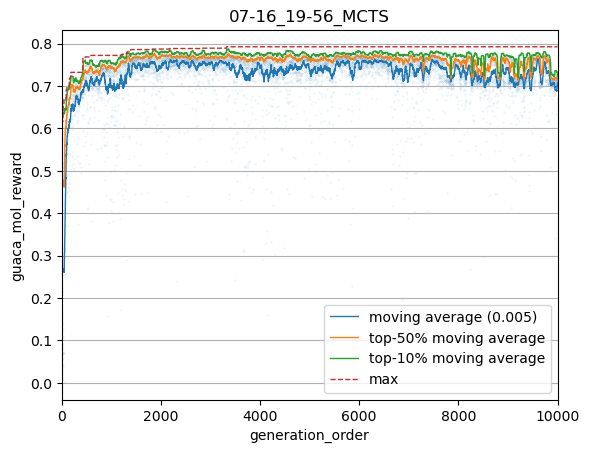

number of generated nodes: 10000
valid rate: 0.7590402742073693
unique rate: 0.5837189374464439
node_per_sec: 27.648765635901608
best_reward: 0.792461012474237
average_reward: 0.7297650984635967
top_10_auc: 0.7782582685834355


In [ ]:
# start generation

# yaml_path = "config/mcts_helm.yaml"
# yaml_path = "config/mcts_smiles.yaml"
# yaml_path = "config/model_test.yaml"
# yaml_path = "config/mcts_d_score.yaml"
# yaml_path = "config/mcts_biot5.yaml"
# yaml_path = "config/mcts_smirks.yaml"
# yaml_path = "config/mcts_jensen.yaml"
# yaml_path = "config/heapq_smiles.yaml"
yaml_path = "config/mol_opt/albuterol_similarity.yaml"

conf = conf_from_yaml(yaml_path, repo_root)
generator = generator_from_conf(conf, repo_root)
generate_and_analyze(generator, conf)
# queue_generations(c1, c2)

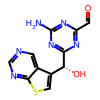

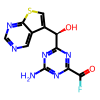

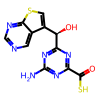

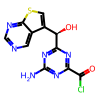

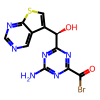

In [4]:
from utils import draw_mol
for c in generator.root.children:
    draw_mol(c.mol(), 100, 100)

In [ ]:
# continue generation
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [16]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load generator and yaml
from generator import Generator
load_dir = "generation_result/06-26_08-51/"
conf = conf_from_yaml("sandbox/" + load_dir + "setting.yaml", repo_root)
generator = generator_from_conf(conf, repo_root)
generator = Generator.load(load_dir + "save.mcts", generator.transition)

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
conf = conf_from_yaml(yaml_path, repo_root)
generator = generator_from_conf(conf, repo_root)
generate_and_analyze(generator, conf)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)